<a href="https://colab.research.google.com/github/MStamirski/Faces/blob/main/Model_all_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colab_Notebooks/SDA_upskill/Faces"

In [ ]:
!pip install import-ipynb

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from keras.metrics import Precision
from keras.metrics import Recall

import import_ipynb

# Import custom functions

In [ ]:
from Dataset_prep import get_labels, get_faces

importing Jupyter notebook from Dataset_prep.ipynb


In [ ]:
from Functions import show_metrics, get_best_threshold, get_tuned_prediction

importing Jupyter notebook from Functions.ipynb


In [ ]:
from Functions_all_labels import prepare_data, show_prediction, show_predictions

importing Jupyter notebook from Functions_all_labels.ipynb


# Data for model

In [ ]:
labels = get_labels()
faces, sex, hair, glasses, hat, beard = get_faces(labels, 'photos_dst/')

Processing face nr 1349
Created dataset contains 5300 faces.


In [ ]:
X, y = prepare_data(faces, sex, hair, glasses, hat, beard, ['F', 'L', 'Y', 'Y', 'Y'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=43)

# Model

In [ ]:
# define a Convolutional Neural Network in PyTorch

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3)                  # 1 input image channel, 64 output channels, kernel 3x3
        self.conv2 = nn.Conv2d(64, 128, 2)                # 64 input image channels, 128 output channels, kernel 2x2
        self.conv3 = nn.Conv2d(128, 576, 2)               # 128 input image channels, 576 output channels, kernel 2x2
        
        self.fc1 = nn.Linear(576 * 14 * 14, 1152)         # input: 576 images of 14x14 dimension (first conv subtracts 2 and divides by 2, second: 1 and 2, third subtracts 1 - from starting 64 side of image)
        self.fc2 = nn.Linear(1152, 5)                     # output: 5 labels


    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))   # Max pooling over a (2, 2) window after first convolution with relu activation
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))   # Max pooling over a (2, 2) window after second convolution with relu activation
        x = F.relu(self.conv3(x))                         # Third convolution with relu activation
        x = torch.flatten(x, 1)                           # flatten all dimensions to connect with fc1 - except batch dimension
        
        x = F.relu(self.fc1(x))                           # fully conected (dense) layer
        x = self.fc2(x)                                   # output with 5 labels (no probability if loss = CrossEntropy, so no Sigmoid)
        
        return x 

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(128, 576, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=112896, out_features=1152, bias=True)
  (fc2): Linear(in_features=1152, out_features=5, bias=True)
)


In [ ]:
params = list(model.parameters())
print(len(params))
for s in range(len(params)):
  print(s, params[s].size()) 

10
0 torch.Size([64, 1, 3, 3])
1 torch.Size([64])
2 torch.Size([128, 64, 2, 2])
3 torch.Size([128])
4 torch.Size([576, 128, 2, 2])
5 torch.Size([576])
6 torch.Size([1152, 112896])
7 torch.Size([1152])
8 torch.Size([5, 1152])
9 torch.Size([5])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# model training

epochs_nr = 20
batch_size = 32

total_train_samples = len(y_train)
total_valid_samples = len(y_val)

total_train_batches = total_train_samples // batch_size
if total_train_samples % batch_size > 0:
  total_train_batches += 1

total_valid_batches = total_valid_samples // batch_size
if total_valid_samples % batch_size > 0:
  total_valid_batches += 1

train_losses = []
valid_losses = []

for epoch in range(epochs_nr):
  train_loss = 0
  valid_loss = 0

  # training
  batch_nr = 0
  model.train()
  for start_batch in range(0, total_train_samples, batch_size):
    end_batch = min(total_train_samples, start_batch+batch_size)
    batch_nr += 1
    
    # float64 in numpy arrays doesn't fit to tensors
    batch_X_train = torch.tensor(X_train[start_batch:end_batch].astype(np.float32))
    batch_y_train = torch.tensor(y_train[start_batch:end_batch].astype(np.float32))

    # additional size for channels (data is in grayscale so this size was missing)
    batch_X_train = batch_X_train.unsqueeze(1)  
       
    optimizer.zero_grad()
    outputs = model(batch_X_train)  
    loss = criterion(outputs, batch_y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * batch_X_train.size(0)
    avg_train_loss = train_loss / (batch_nr * batch_size)

    print(f"\rTraining: {batch_nr}/{total_train_batches}, train loss: {avg_train_loss:.4f}", end="")
    
  # validation
  batch_nr = 0
  model.eval()
  print("")
  for start_batch in range(0, total_valid_samples, batch_size):
    end_batch = min(total_valid_samples, start_batch+batch_size)
    batch_nr += 1

    batch_X_valid = torch.tensor(X_val[start_batch:end_batch].astype(np.float32))
    batch_y_valid = torch.tensor(y_val[start_batch:end_batch].astype(np.float32))

    batch_X_valid = batch_X_valid.unsqueeze(1)  

    with torch.no_grad():
      outputs = model(batch_X_valid)
      loss = criterion(outputs, batch_y_valid)

    valid_loss += loss.item() * batch_X_valid.size(0)
    avg_valid_loss = valid_loss / (batch_nr * batch_size)

    # statistics for batch
    print(f"\rValidation: {batch_nr}/{total_valid_batches}, val loss: {avg_valid_loss:.4f}", end="")

  # calculate average losses for epoch
  train_loss = train_loss/total_train_samples
  valid_loss = valid_loss/total_valid_samples
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
        
  # print statistics 
  print(f"\nEpoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}\n")

Training: 106/106, train loss: 1.6569
Validation: 27/27, val loss: 1.2498
Epoch: 1, Training Loss: 1.6569, Validation Loss: 1.2734

Training: 106/106, train loss: 1.3042
Validation: 27/27, val loss: 1.1235
Epoch: 2, Training Loss: 1.3042, Validation Loss: 1.1447

Training: 106/106, train loss: 1.1493
Validation: 27/27, val loss: 1.0467
Epoch: 3, Training Loss: 1.1493, Validation Loss: 1.0665

Training: 106/106, train loss: 1.0212
Validation: 27/27, val loss: 1.0281
Epoch: 4, Training Loss: 1.0212, Validation Loss: 1.0475

Training: 106/106, train loss: 0.9152
Validation: 27/27, val loss: 0.9654
Epoch: 5, Training Loss: 0.9152, Validation Loss: 0.9836

Training: 106/106, train loss: 0.8414
Validation: 27/27, val loss: 1.0025
Epoch: 6, Training Loss: 0.8414, Validation Loss: 1.0214

Training: 106/106, train loss: 0.8087
Validation: 27/27, val loss: 0.9179
Epoch: 7, Training Loss: 0.8087, Validation Loss: 0.9352

Training: 106/106, train loss: 0.7671
Validation: 27/27, val loss: 0.9710
Ep

# Custom functions

In [ ]:
def make_prediction(model, X_test, y_test):

  Xt = torch.tensor(X_test.astype(np.float32))
  Xt = Xt.unsqueeze(1)

  with torch.no_grad():
    y_pred = model(Xt)

  print("\nMetrics before tuning")
  show_metrics(y_test, y_pred)

  threshold = get_best_threshold(y_test, y_pred)
  print(f"\nBest threshold: {threshold}")

  y_pred_tuned = get_tuned_prediction(y_pred, threshold)
  print("\nMetrics after tuning")
  show_metrics(y_test, y_pred_tuned)

  return y_pred_tuned

In [ ]:
def plot_history(train_loss, valid_loss):
  
  fig, ax = plt.subplots(figsize=[8,6])
  ax.grid()
  ax.plot(train_loss, 'r',linewidth=3.0, label='training')
  ax.plot(valid_loss, 'b',linewidth=3.0, label='validation')
  ax.set_xlabel('Epochs')
  ax.legend()
  ax.set_title('Loss function')
  plt.show()

# Outcome

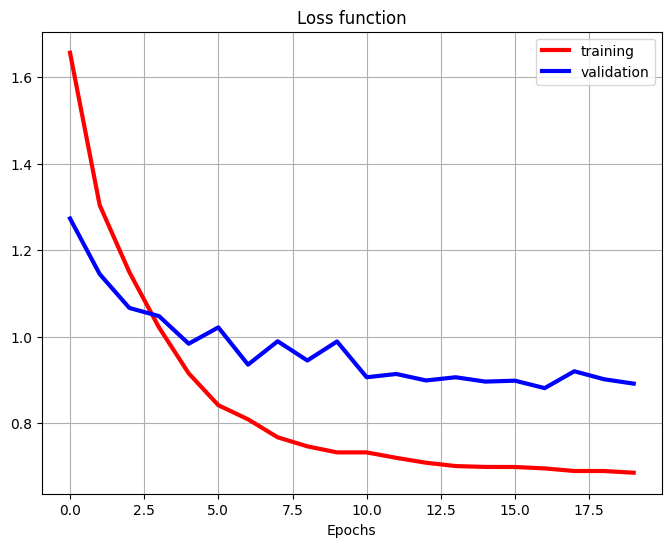

In [ ]:
plot_history(train_losses, valid_losses)

In [ ]:
y_pred_tuned = make_prediction(model, X_test, y_test)


Metrics before tuning
Precision: 0.5929502844810486
Recall: 0.9753772616386414
F1 Score: 0.7375375628471375

Best threshold: 0.9500000000000001

Metrics after tuning
Precision: 0.6289569139480591
Recall: 0.962668776512146
F1 Score: 0.7608285546302795




Predictions for label: [Sex] value: [0]



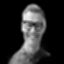


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     0         1



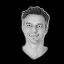


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         1
Hat       0         0
Beard     0         1



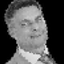


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



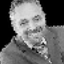


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



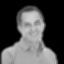


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Sex] value [1]



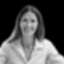


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



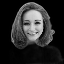


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



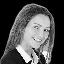


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



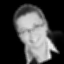


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         1
Glasses   1         0
Hat       0         0
Beard     0         0



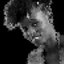


LABELS    VALUES    PREDICTIONS
Sex       1         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         1


Predictions for label: [Hair] value: [0]



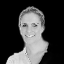


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



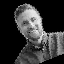


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         1
Hat       0         0
Beard     1         1



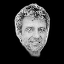


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



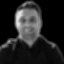


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



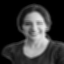


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Hair] value [1]



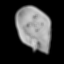


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



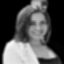


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



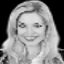


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



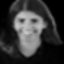


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



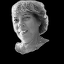


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Glasses] value: [0]



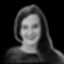


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



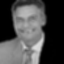


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         1



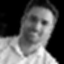


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



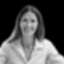


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



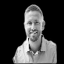


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1


Predictions for label: [Glasses] value [1]



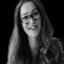


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



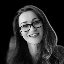


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



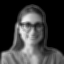


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



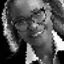


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



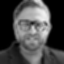


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     1         1


Predictions for label: [Hat] value: [0]



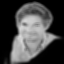


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         1
Beard     1         1



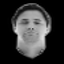


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         1
Hat       0         0
Beard     0         1



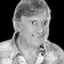


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         1
Glasses   0         0
Hat       0         0
Beard     0         0



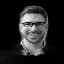


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     1         1



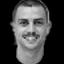


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         1
Hat       0         0
Beard     1         1


Predictions for label: [Hat] value [1]



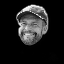


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     1         1



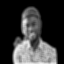


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       1         0
Beard     1         1



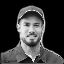


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     1         1



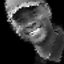


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     0         0



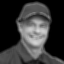


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     0         0


Predictions for label: [Beard] value: [0]



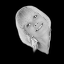


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



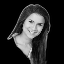


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



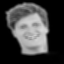


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       0         1
Beard     0         1



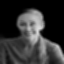


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



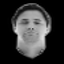


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         1
Hat       0         0
Beard     0         1


Predictions for label: [Beard] value [1]



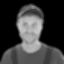


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     1         1



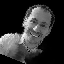


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



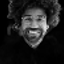


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     1         1



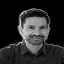


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



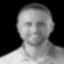


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1


In [ ]:
show_predictions(X_test, y_test, y_pred_tuned)